# Requerimiento 2: Análisis de Similitud entre Artículos

## Descripción del Requerimiento

Este notebook implementa un **análisis comparativo de algoritmos de similitud textual** para evaluar la similitud entre abstracts de artículos científicos.

### Objetivos:
1. Cargar y preprocesar archivo BibTeX consolidado
2. Eliminar duplicados por título
3. Comparar 6 algoritmos de similitud textual

### Categorías de Algoritmos:

#### Algoritmos Clásicos (No supervisados):
1. **Levenshtein**: Distancia de edición entre caracteres
2. **Coseno TF-IDF**: Similitud vectorial con pesos TF-IDF
3. **Jaccard**: Intersección de conjuntos de palabras
4. **Euclidiana**: Distancia en espacio vectorial

#### Algoritmos Basados en IA (Supervisados):
5. **SBERT**: Embeddings semánticos con Sentence-BERT
6. **Cross-Encoder**: Evaluación directa de pares de texto

### Umbrales de Interpretación:

| Rango | Interpretación |
|-------|----------------|
| ≥ 0.80 | Muy similares |
| 0.50 - 0.79 | Similitud moderada |
| 0.20 - 0.49 | Poco similares |
| < 0.20 | No similares |

# 1. Carga y Deduplicación del Archivo BibTeX

Esta celda carga el archivo consolidado y elimina artículos duplicados.

#### Proceso:

##### 1. Configuración del Parser
```python
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True
```
- **`common_strings=True`**: Expande abreviaturas comunes de BibTeX
- **`expect_multiple_parse=True`**: Suprime warnings de múltiples entradas

##### 2. Lectura del Archivo
```python
with open(CONSOLIDADO_PATH, encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)
```
- **Encoding UTF-8**: Soporta caracteres especiales
- **Context manager**: Cierre automático del archivo

##### 3. Extracción de Campos
```python
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })
```
- Extrae título, autores, keywords y abstract
- Manejo de valores faltantes con `entry.get(campo, "")`

##### 4. Deduplicación por Título
```python
df_unique = df.drop_duplicates(subset="title", keep="first")
```
- **`keep="first"`**: Mantiene la primera aparición de cada título
- Los títulos son únicos en publicaciones académicas

##### 5. Guardado de Resultados
```python
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)
```
- **`articulos_unicos.csv`**: Dataset limpio para análisis
- **`articulos_repetidos.csv`**: Duplicados para auditoría

In [2]:
import bibtexparser
import pandas as pd
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado
CONSOLIDADO_PATH = os.getenv("CONSOLIDADO_PATH", "../salidas/consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(CONSOLIDADO_PATH):
    print(f"Error: No se encuentra el archivo en {CONSOLIDADO_PATH}")
    print(f"Directorio actual: {os.getcwd()}")
    print(f"Archivos disponibles:")
    # Buscar archivos .bib en directorios comunes
    for root, dirs, files in os.walk(".."):
        for file in files:
            if file.endswith("consolidado.bib"):
                print(f"Encontrado: {os.path.join(root, file)}")
    raise FileNotFoundError(f"No se encuentra {CONSOLIDADO_PATH}")

print(f"Leyendo archivo: {CONSOLIDADO_PATH}")

# Configurar el parser
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True  # Evita el warning

# Leer TODO el archivo de una vez
with open(CONSOLIDADO_PATH, encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)

# Extraer la información
data = []
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })

df = pd.DataFrame(data)

# Eliminar duplicados por título
df_unique = df.drop_duplicates(subset="title", keep="first")
df_duplicates = df[df.duplicated(subset="title", keep=False)]

# Guardar resultados
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)

print(f"Artículos totales: {len(df)}")
print(f"Artículos únicos: {len(df_unique)}")
print(f"Artículos repetidos: {len(df_duplicates)}")

df_unique.head()

Leyendo archivo: C:\Users\camil\OneDrive\Escritorio\proyectoAnalisisAlgoritmos\proyecto\consolidado.bib
Artículos totales: 10226
Artículos únicos: 10189
Artículos repetidos: 38
Artículos totales: 10226
Artículos únicos: 10189
Artículos repetidos: 38


,title,authors,keywords,abstract
0,Do Robots Dream of Passing a Programming Course?,"Torres, Nicolás",Training;Computational modeling;Instruments;Na...,Programming typically involves humans formulat...
1,WeAIR: Wearable Swarm Sensors for Air Quality ...,"Dimitri, Giovanna Maria and Parri, Lorenzo and...",Temperature measurement;Climate change;Cloud c...,The present study proposes the implementation ...
2,Discriminative-Generative Representation Learn...,"Li, Duanjiao and Chen, Yun and Zhang, Ying and...",Representation learning;Semantics;Asia;Self-su...,"Generative Adversarial Networks (GANs), as a f..."
3,3 Generative AI Models and LLM: Training Techn...,"Arun, C. and Karthick, S. and Selvakumara Samy...",,Generative artificial intelligence (AI) has be...
4,Virtual Human: A Comprehensive Survey on Acade...,"Cui, Lipeng and Liu, Jiarui",Digital humans;Motion capture;Face recognition...,As a creative method for virtual human individ...


# 2.Selección de Artículos para Comparación

Esta celda selecciona una muestra de artículos para análisis de similitud.

#### Estrategia de Selección:

```python
abstracts = df["abstract"].head(3).tolist()
titles = df["title"].head(3).tolist()
```

**Características**:
- Toma los primeros N artículos del DataFrame
- Simple y reproducible
- Puede ajustarse según necesidad (`.head(N)` o `.sample(N)`)

#### Alternativas de Selección:

**Selección Aleatoria**:
```python
indices = random.sample(range(len(df)), 3)
abstracts = df.iloc[indices]["abstract"].tolist()
```

**Selección por Keywords**:
```python
mask = df["keywords"].str.contains("generative", case=False, na=False)
sample = df[mask].head(3)
```

**Selección por Longitud**:
```python
df["abstract_len"] = df["abstract"].str.len()
sample = df[(df["abstract_len"] > 500) & (df["abstract_len"] < 700)].head(3)
```

In [3]:
# Selección por índice: configura aquí los dos artículos a comparar
# Cambia estos valores por los índices deseados (dos índices, 0-based).
SELECT_IDX_A = 0  # índice del primer artículo
SELECT_IDX_B = 1  # índice del segundo artículo

# --- Validar índices ---
n = len(df)
if SELECT_IDX_A < 0 or SELECT_IDX_A >= n or SELECT_IDX_B < 0 or SELECT_IDX_B >= n:
    raise IndexError(f'Índices inválidos. El DataFrame tiene {n} filas. Utiliza valores entre 0 y {n-1}.' )

# --- Extraer títulos y abstracts de los índices seleccionados ---
selected_indices = [SELECT_IDX_A, SELECT_IDX_B]
titles = df.loc[selected_indices, 'title'].fillna('').tolist()
abstracts = df.loc[selected_indices, 'abstract'].fillna('').tolist()

# --- Imprimir título y abstract completo de cada artículo seleccionado ---
for i, (t, a) in enumerate(zip(titles, abstracts)):
    print(f"Artículo {i} (índice {selected_indices[i]}): {t}")
    print(a)

Artículo 0 (índice 0): Do Robots Dream of Passing a Programming Course?
Programming typically involves humans formulating instructions for a computer to execute computations. If we adhere to this definition, a machine would seemingly lack the capability to autonomously design algorithms. However, recent generative Artificial Intelligence models, such as GPT, have demonstrated an impressive ability to perform complex human tasks with remarkable precision. In this paper, we initially showcase how an AI model can successfully complete an entire college-level programming course, akin to one of the top-performing students in the class. We then put forward strategies for crafting programming exercises that enable educators to effectively integrate these innovative technologies into their teaching methods. Lastly, we illustrate how these models can transition from being perceived as a potential threat to educators to becoming a valuable opportunity when employed judiciously.
Artículo 1 (índic

# Algoritmo 1: Distancia de Levenshtein

La **distancia de Levenshtein** mide el número mínimo de operaciones de edición (inserción, eliminación, sustitución) necesarias para transformar un texto en otro.

#### Fundamento Matemático

Para dos cadenas **a** y **b**, la distancia de Levenshtein se define recursivamente:

```
lev(a,b) = {
    |a|                                  si |b| = 0
    |b|                                  si |a| = 0
    lev(tail(a), tail(b))                si a[0] = b[0]
    1 + min {
        lev(tail(a), b)                  (eliminación)
        lev(a, tail(b))                  (inserción)
        lev(tail(a), tail(b))            (sustitución)
    }                                    en otro caso
}
```

#### Conversión a Similitud

```python
similarity = 1 - (distance / max_length)
```

**Rango**: [0, 1]
- **1.0** = textos idénticos
- **0.0** = textos completamente diferentes

#### Implementación

```python
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    return similarity
```

**Complejidad**: O(m × n) donde m, n son longitudes de los textos

#### Ventajas
- Simplicidad y facilidad de implementación
- Determinístico (siempre da el mismo resultado)
- Sensible a errores ortográficos
- No requiere entrenamiento

#### Desventajas
- Opera a nivel de caracteres, no entiende semántica
- Sensible a longitud de textos
- No detecta sinónimos o paráfrasis
- El orden de palabras afecta significativamente

In [4]:
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    
    # Interpretación del resultado
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen cierta similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    print(f"Similitud de Levenshtein: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity


levenshtein_similarity(abstracts[0], abstracts[1])


Similitud de Levenshtein: 0.219
Interpretación: Los textos son poco similares.


0.21857923497267762

# Algoritmo 2: Similitud del Coseno con TF-IDF

La **similitud del coseno** mide el ángulo entre dos vectores en un espacio multidimensional. Combinada con **TF-IDF**, captura la importancia relativa de las palabras.

#### Fundamento Matemático

**TF-IDF (Term Frequency - Inverse Document Frequency)**

```
TF(t, d) = (Frecuencia de término t en documento d) / (Total de términos en d)
IDF(t, D) = log(Total de documentos / Documentos que contienen t)
TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)
```

**Similitud del Coseno**

Para dos vectores **A** y **B**:

```
cos(θ) = (A · B) / (||A|| × ||B||)
```

Donde:
- **A · B** = producto punto = Σ(Aᵢ × Bᵢ)
- **||A||** = norma = √(Σ Aᵢ²)
- **θ** = ángulo entre vectores

**Rango**: [-1, 1]
- **1**: Vectores idénticos (θ = 0°)
- **0**: Vectores ortogonales (θ = 90°)
- **-1**: Vectores opuestos (θ = 180°)

#### Implementación

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)
```

**Parámetros importantes**:
- **`stop_words='english'`**: Elimina palabras comunes (the, and, is...)
- **`max_features`**: Limita vocabulario
- **`ngram_range`**: Incluye n-gramas

#### Interpretación de Resultados

**Matriz de Similitud**:
- **Diagonal**: Siempre 1.0 (cada documento consigo mismo)
- **Valores fuera de diagonal**: Similitud entre pares de documentos

#### Ventajas
- Opera a nivel de palabras, no caracteres
- TF-IDF pondera palabras importantes
- Normalizado por magnitud de vectores
- Eficiente y escalable
- Interpretable

#### Desventajas
- No captura similitud semántica (sinónimos)
- Bag of words: ignora orden de palabras
- Vocabulario cerrado (solo palabras vistas)
- Vectores dispersos (sparse)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def interpretar_similitud(valor):
    """Interpreta el nivel de similitud según el valor de coseno."""
    if valor >= 0.8:
        return "Los textos son muy similares."
    elif valor >= 0.5:
        return "Los textos tienen similitud moderada."
    elif valor >= 0.2:
        return "Los textos son poco similares."
    else:
        return "Los textos no son similares."

# --- Cálculo del TF-IDF y similitud ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)

# --- Impresión de resultados ---
print("Matriz de similitud de coseno:")
print(cosine_sim)
print("\nInterpretación par a par:\n")

# Recorre cada par de textos (sin repetir)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        valor = cosine_sim[i][j]
        print(f"Similitud entre Abstract {i} y Abstract {j}: {valor:.3f} → {interpretar_similitud(valor)}")


Matriz de similitud de coseno:
[[1.        0.0387515]
 [0.0387515 1.       ]]

Interpretación par a par:

Similitud entre Abstract 0 y Abstract 1: 0.039 → Los textos no son similares.


# Algoritmo 3: Similitud de Jaccard

El **índice de Jaccard** mide la similitud entre conjuntos calculando la proporción de elementos comunes.

#### Fundamento Matemático

Para dos conjuntos **A** y **B**:

```
J(A, B) = |A ∩ B| / |A ∪ B|
```

Donde:
- **A ∩ B** = Intersección (elementos en ambos)
- **A ∪ B** = Unión (elementos en al menos uno)
- **| |** = Cardinalidad (número de elementos)

**Rango**: [0, 1]
- **1**: Conjuntos idénticos
- **0**: Sin elementos comunes

#### Ejemplo

**Texto 1**: "machine learning models"
**Texto 2**: "deep learning networks"

```
A = {machine, learning, models}
B = {deep, learning, networks}
A ∩ B = {learning}                           → |A ∩ B| = 1
A ∪ B = {machine, learning, models, deep, networks} → |A ∪ B| = 5
J(A, B) = 1 / 5 = 0.20
```

#### Implementación

```python
def jaccard_similarity(a, b):
    a_set = set(a.lower().split())
    b_set = set(b.lower().split())
    intersection = len(a_set & b_set)
    union = len(a_set | b_set)
    return intersection / union
```

**Operaciones de conjuntos en Python**:
- `&` = Intersección
- `|` = Unión
- `set()` = Elimina duplicados automáticamente

#### Ventajas
- Muy simple de entender e implementar
- Rápido: operaciones de conjuntos son O(n)
- Simétrico: J(A,B) = J(B,A)
- No requiere pesos ni entrenamiento
- Robusto a duplicados

#### Desventajas
- Ignora frecuencia de palabras
- Ignora orden de palabras
- No captura similitud semántica
- Sensible a longitud de textos
- Cuenta stopwords igual que palabras importantes

In [6]:
def jaccard_similarity(a, b):
    # Convertir a conjuntos de palabras
    a_set, b_set = set(a.lower().split()), set(b.lower().split())
    similarity = len(a_set & b_set) / len(a_set | b_set)
    
    # Interpretación de la similitud
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    # Mostrar resultados
    print(f"Similitud de Jaccard: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity

# Ejemplo de uso
jaccard_similarity(abstracts[0], abstracts[1])


Similitud de Jaccard: 0.078
Interpretación: Los textos no son similares.


0.0782122905027933

# Algoritmo 4: Similitud Euclidiana

La **distancia euclidiana** mide la distancia geométrica entre dos puntos en un espacio multidimensional.

#### Fundamento Matemático

**Distancia Euclidiana**:

Para dos vectores **A** y **B** de dimensión n:

```
d(A, B) = √(Σᵢ (Aᵢ - Bᵢ)²)
```

**Conversión a Similitud**:

```
similarity = 1 / (1 + distance)
```

**Rango**: [0, 1]
- **1**: Vectores idénticos (distancia = 0)
- **→0**: Vectores muy diferentes (distancia → ∞)

#### Implementación

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)
distances = euclidean_distances(X)
similarities = 1 / (1 + distances)
```

**Diferencia con TF-IDF**:
- **CountVectorizer**: Frecuencias simples (1, 2, 3...)
- **TfidfVectorizer**: Frecuencias ponderadas

#### Ventajas
- Intuitivo: distancia geométrica familiar
- Sensible a magnitud (captura diferencias de frecuencia)
- Fácil de visualizar en 2D/3D

#### Desventajas
- Sensible a dimensionalidad alta
- Sensible a escala (palabras frecuentes dominan)
- No normalizado por longitud de texto
- Menos usado que coseno para textos

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Vectorizar los textos (sin stopwords en inglés)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Calcular distancias euclidianas
distances = euclidean_distances(X)

# Convertir a similitud (1 / (1 + distancia))
similarities = 1 / (1 + distances)

# Mostrar matriz de similitudes con interpretación
print("Matriz de similitud euclidiana:")
print(similarities)

# Interpretar los valores (solo pares distintos)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        sim = similarities[i, j]
        if sim >= 0.8:
            interpretation = "Los textos son muy similares."
        elif sim >= 0.5:
            interpretation = "Los textos tienen similitud moderada."
        elif sim >= 0.2:
            interpretation = "Los textos son poco similares."
        else:
            interpretation = "Los textos no son similares."
        
        print(f"\nSimilitud entre Abstract {i} y {j}: {sim:.3f}")
        print(f"Interpretación: {interpretation}")


Matriz de similitud euclidiana:
[[1.         0.06972692]
 [0.06972692 1.        ]]

Similitud entre Abstract 0 y 1: 0.070
Interpretación: Los textos no son similares.


# Algoritmo 5: SBERT (Sentence-BERT)

**SBERT** es un modelo de embeddings semánticos basado en transformers que captura el significado contextual de oraciones completas.

#### Fundamento Teórico

**Arquitectura**:
```
Texto → BERT → Pooling → Embedding (768 dim) → Similitud de Coseno
```

**Diferencias con BERT tradicional**:
- **BERT**: Requiere concatenar textos y procesar juntos (lento)
- **SBERT**: Genera embeddings independientes (rápido)

**Proceso**:
1. Tokenización del texto
2. Paso por capas transformer
3. Mean pooling de tokens
4. Normalización del vector resultante

#### Implementación

```python
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=True)
similarity = util.cos_sim(embeddings[0], embeddings[1])
```

**Modelos populares**:
- **`all-MiniLM-L6-v2`**: Rápido, 384 dimensiones
- **`all-mpnet-base-v2`**: Mejor calidad, 768 dimensiones
- **`paraphrase-multilingual`**: Soporte multilingüe

#### Ventajas
- **Semántica profunda**: Entiende sinónimos, paráfrasis
- **Contexto**: Captura significado según contexto
- **Pre-entrenado**: No requiere entrenamiento adicional
- **Eficiente**: Embeddings se calculan una vez
- **Estado del arte**: Mejor rendimiento en benchmarks

#### Desventajas
- Requiere GPU para velocidad óptima
- Modelos grandes (100+ MB)
- Caja negra: difícil interpretar
- Requiere instalación de librerías pesadas
- Puede ser excesivo para tareas simples

In [8]:

from sentence_transformers import SentenceTransformer, util
import numpy as np

# --- Textos (abstracts) ---
texts = [abstracts[0], abstracts[1]]  # puedes cambiar a tus abstracts

# --- Cargar modelo SBERT ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings ---
embeddings = model.encode(texts, convert_to_tensor=True)

# --- Calcular similitud de coseno ---
similarity = util.cos_sim(embeddings[0], embeddings[1]).item()

# --- Interpretar el resultado ---
if similarity >= 0.8:
    interpretation = "Los textos son muy similares."
elif similarity >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif similarity >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Similitud SBERT: {similarity:.3f}")
print(f"Interpretación: {interpretation}")


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Similitud SBERT: 0.189
Interpretación: Los textos no son similares.


# Algoritmo 6: Cross-Encoder

El **Cross-Encoder** evalúa directamente pares de textos mediante atención cruzada, proporcionando la evaluación más precisa de similitud.

#### Fundamento Teórico

**Arquitectura**:
```
[CLS] Texto1 [SEP] Texto2 [SEP] → BERT → Clasificador → Score
```

**Diferencia con Bi-Encoder (SBERT)**:

| Aspecto | Bi-Encoder (SBERT) | Cross-Encoder |
|---------|-------------------|---------------|
| Procesamiento | Textos por separado | Textos concatenados |
| Atención | Independiente | Cruzada (texto1 ↔ texto2) |
| Velocidad | Rápido (O(n)) | Lento (O(n²)) |
| Precisión | Buena | Excelente |
| Uso | Búsqueda inicial | Re-ranking |

#### Implementación

```python
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
score = cross_encoder.predict([[text1, text2]])[0]
```

**Normalización del score**:
```python
# Algunos modelos devuelven scores no normalizados
prob = 1 / (1 + np.exp(-score))  # Función sigmoide
```

#### Modelos Populares
- **`ms-marco-MiniLM-L-6-v2`**: Entrenado en MS MARCO (búsqueda)
- **`nli-deberta-v3-base`**: Entrenado en inferencia natural
- **`stsb-roberta-base`**: Entrenado en similitud semántica

#### Ventajas
- **Máxima precisión**: Atención cruzada captura interacciones sutiles
- **Estado del arte**: Mejor rendimiento en benchmarks
- **Flexible**: Puede entrenarse para tareas específicas
- **Interpretable**: Scores directos de similitud

#### Desventajas
- **Muy lento**: Debe procesar cada par individualmente
- **No escalable**: O(n²) para n documentos
- **Uso típico**: Re-ranking de top-k resultados
- **Requiere GPU**: Especialmente para conjuntos grandes
- **No genera embeddings**: No se pueden cachear

In [9]:
from sentence_transformers import CrossEncoder
import numpy as np

# --- Cargar modelo ---
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# --- Evaluar similitud directa entre dos textos ---
pair = [[abstracts[0], abstracts[1]]]
score = cross_encoder.predict(pair)[0]

# --- Normalizar (si el score no está entre 0 y 1) ---
prob = 1 / (1 + np.exp(-score)) if score > 1 or score < 0 else score

# --- Interpretación ---
if prob >= 0.8:
    interpretation = "Los textos son muy similares."
elif prob >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif prob >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Puntaje Cross-Encoder: {score:.3f}")
print(f"Probabilidad normalizada: {prob:.3f}")
print(f"Interpretación: {interpretation}")


Puntaje Cross-Encoder: -6.766
Probabilidad normalizada: 0.001
Interpretación: Los textos no son similares.


C:\Users\camil\AppData\Local\Temp\ipykernel_11400\2903663901.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos = float(cosine_similarity(mat[0], mat[1]))


Resultados (similitudes):
 - Levenshtein: 0.21857923497267762
 - TFIDF_Cosine: 0.03875150217190518
 - Jaccard: 0.0782122905027933
 - Euclidean: 0.06972691561653295
 - SBERT: 0.1889268010854721
 - CrossEncoder: 0.0011512970086187124

Tiempos de inferencia (segundos):
 - Levenshtein: 0.018638 s
 - TFIDF_Cosine: 0.080159 s
 - Jaccard: 0.000188 s
 - Euclidean: 0.010983 s
 - SBERT: 0.610057 s
 - CrossEncoder: 0.427661 s

Tiempos de carga de modelos (si aplicable):
 - sbert_load_s: 3.799 s
 - cross_load_s: 2.205 s
Guardado: outputs/benchmark_times.png
Guardado: outputs/benchmark_times.png


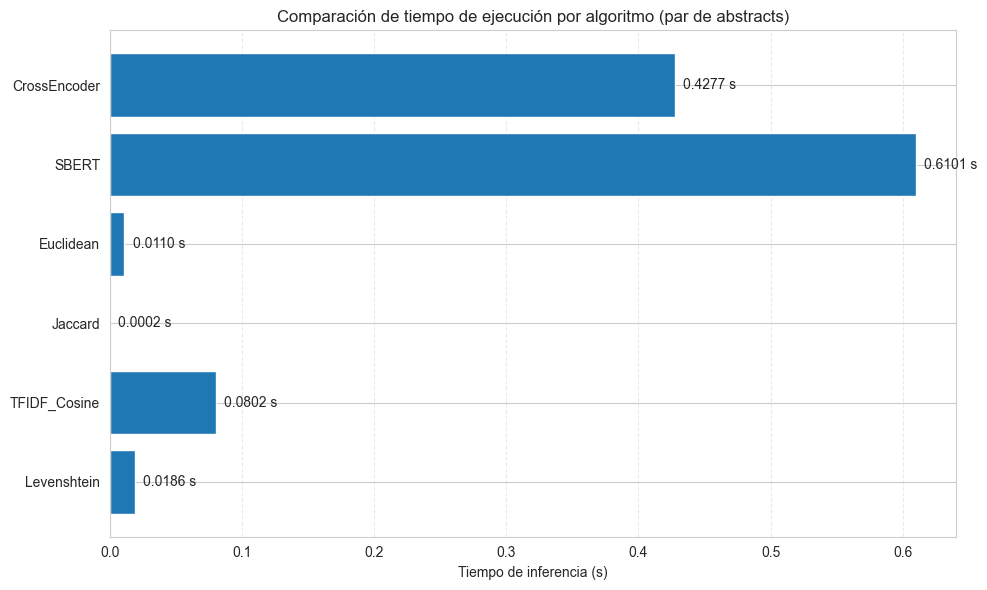

Guardado: outputs/benchmark_similarities.png


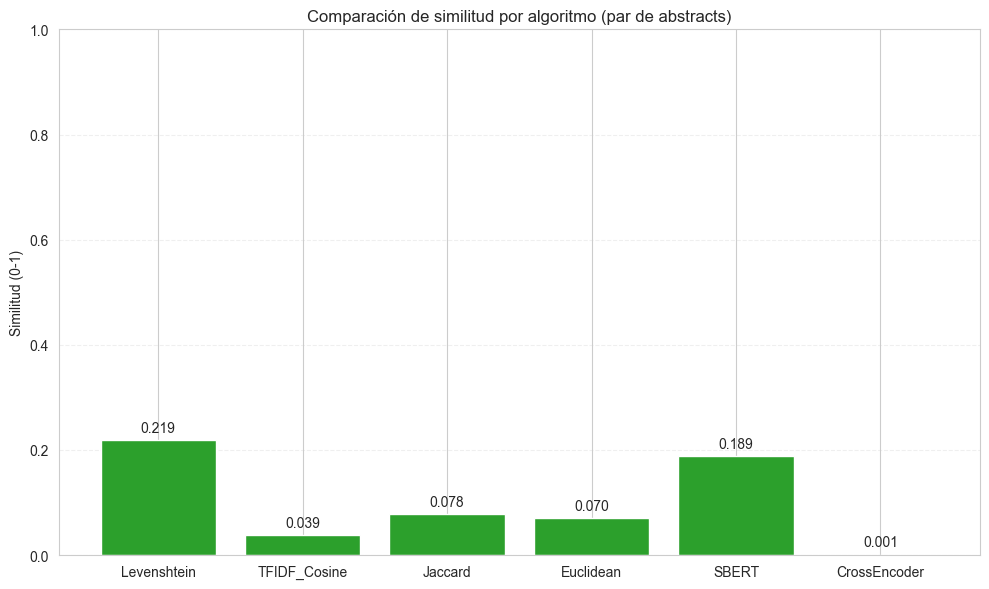

Guardado: outputs\benchmark_results.csv
Guardado: outputs\benchmark_results.json
Guardado legible: outputs\benchmark_results.txt


In [20]:
# Fragmento: benchmark de tiempos y gráfica de comparación
import time
import numpy as np
import matplotlib.pyplot as plt

# Intentar obtener 'abstracts' del entorno del notebook si no está definido
try:
    abstracts  # noqa: F821
except NameError:
    try:
        abstracts = df.loc[[SELECT_IDX_A, SELECT_IDX_B], "abstract"].fillna("").tolist()
    except Exception as e:
        raise RuntimeError("No se encontró 'abstracts' ni 'df' en el entorno. Define 'abstracts' con al menos dos textos.") from e

if len(abstracts) < 2:
    raise ValueError("Se necesitan al menos dos abstracts para comparar (abstracts[0] y abstracts[1]).")

text_a, text_b = abstracts[0], abstracts[1]

# Definir funciones de cada algoritmo (solo la parte de cálculo de similitud)
def time_wrapper(func, *args, repeat=1):
    start = time.perf_counter()
    for _ in range(repeat):
        result = func(*args)
    end = time.perf_counter()
    return result, (end - start) / repeat

# 1) Levenshtein
def levenshtein_infer(a, b):
    import Levenshtein
    dist = Levenshtein.distance(a, b)
    max_len = max(len(a), len(b)) or 1
    sim = 1 - dist / max_len
    return sim

# 2) TF-IDF + Coseno
def tfidf_cosine_infer(a, b):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    vectorizer = TfidfVectorizer(stop_words='english')
    mat = vectorizer.fit_transform([a, b])
    cos = float(cosine_similarity(mat[0], mat[1]))
    return cos

# 3) Jaccard
def jaccard_infer(a, b):
    a_set = set(a.lower().split())
    b_set = set(b.lower().split())
    if len(a_set | b_set) == 0:
        return 0.0
    return len(a_set & b_set) / len(a_set | b_set)

# 4) Euclidiana (CountVectorizer + euclidean_distances -> convert to similarity)
def euclidean_infer(a, b):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics.pairwise import euclidean_distances
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([a, b]).toarray()
    dist = euclidean_distances(X)[0, 1]
    sim = 1 / (1 + dist)
    return float(sim)

# 5) SBERT (Bi-Encoder) - model load measured separately
def sbert_infer(model, a, b):
    from sentence_transformers import util
    emb = model.encode([a, b], convert_to_tensor=True)
    cos = util.cos_sim(emb[0], emb[1]).item()
    return float(cos)

# 6) Cross-Encoder - model load measured separately
def crossencoder_infer(model, a, b):
    score = model.predict([[a, b]])[0]
    # Algunos cross-encoders devuelven scores en rango amplio; opcionalmente normalizamos con sigmoide:
    import numpy as _np
    prob = 1 / (1 + _np.exp(-score)) if (score > 1 or score < 0) else score
    return float(prob)

# Cargar modelos SBERT y CrossEncoder (medimos tiempos de carga)
sbert_model = None
cross_model = None
load_times = {}

try:
    t0 = time.perf_counter()
    from sentence_transformers import SentenceTransformer
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    load_times['sbert_load_s'] = time.perf_counter() - t0
except Exception as e:
    load_times['sbert_load_s'] = None
    print("Advertencia: no se pudo cargar SBERT:", e)

try:
    t0 = time.perf_counter()
    from sentence_transformers import CrossEncoder
    cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    load_times['cross_load_s'] = time.perf_counter() - t0
except Exception as e:
    load_times['cross_load_s'] = None
    print("Advertencia: no se pudo cargar Cross-Encoder:", e)

# Ejecutar cada algoritmo (medimos solo la parte de inferencia)
results = {}
times = {}

# 1 Levenshtein
res, t = time_wrapper(levenshtein_infer, text_a, text_b)
results['Levenshtein'] = res
times['Levenshtein'] = t

# 2 TF-IDF + Coseno
res, t = time_wrapper(tfidf_cosine_infer, text_a, text_b)
results['TFIDF_Cosine'] = res
times['TFIDF_Cosine'] = t

# 3 Jaccard
res, t = time_wrapper(jaccard_infer, text_a, text_b)
results['Jaccard'] = res
times['Jaccard'] = t

# 4 Euclidiana
res, t = time_wrapper(euclidean_infer, text_a, text_b)
results['Euclidean'] = res
times['Euclidean'] = t

# 5 SBERT (si cargado)
if sbert_model is not None:
    res, t = time_wrapper(sbert_infer, sbert_model, text_a, text_b)
    results['SBERT'] = res
    times['SBERT'] = t
else:
    results['SBERT'] = None
    times['SBERT'] = np.nan

# 6 Cross-Encoder (si cargado)
if cross_model is not None:
    res, t = time_wrapper(crossencoder_infer, cross_model, text_a, text_b)
    results['CrossEncoder'] = res
    times['CrossEncoder'] = t
else:
    results['CrossEncoder'] = None
    times['CrossEncoder'] = np.nan

# Mostrar resultados y tiempos
print("Resultados (similitudes):")
for k, v in results.items():
    print(f" - {k}: {v}")

print("\nTiempos de inferencia (segundos):")
for k, v in times.items():
    print(f" - {k}: {v:.6f} s")

print("\nTiempos de carga de modelos (si aplicable):")
for k, v in load_times.items():
    print(f" - {k}: {v if v is None else f'{v:.3f} s'}")

# Graficar comparación de tiempos de inferencia
labels = list(times.keys())
vals = [times[k] if (times[k] is not None and not np.isnan(times[k])) else 0.0 for k in labels]

fig1 = plt.figure(figsize=(10, 6))
bars = plt.barh(labels, vals, color='tab:blue')
plt.xlabel('Tiempo de inferencia (s)')
plt.title('Comparación de tiempo de ejecución por algoritmo (par de abstracts)')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Anotar valores en cada barra
for bar, v in zip(bars, vals):
    plt.text(v + max(vals)*0.01, bar.get_y() + bar.get_height()/2, f"{v:.4f} s", va='center')

plt.tight_layout()
# Guardar figura de tiempos
import os
os.makedirs('outputs', exist_ok=True)
fig1.savefig(os.path.join('outputs', 'benchmark_times.png'), dpi=200, bbox_inches='tight')
print("Guardado: outputs/benchmark_times.png")
plt.show()

# --- Gráfica adicional: Comparación de similitudes ---
# Construir lista de etiquetas y valores (sustituimos None por 0.0)
sim_labels = list(results.keys())
sim_vals = [results[k] if (results[k] is not None) else 0.0 for k in sim_labels]

fig2 = plt.figure(figsize=(10, 6))
bars2 = plt.bar(sim_labels, sim_vals, color='tab:green')
plt.ylabel('Similitud (0-1)')
plt.title('Comparación de similitud por algoritmo (par de abstracts)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Anotar valores sobre cada barra
for bar, v in zip(bars2, sim_vals):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout()
# Guardar figura de similitudes
fig2.savefig(os.path.join('outputs', 'benchmark_similarities.png'), dpi=200, bbox_inches='tight')
print("Guardado: outputs/benchmark_similarities.png")
plt.show()

# --- Guardar resultados en CSV / JSON / TXT para uso en HTML ---
import pandas as _pd
algorithms = sim_labels
similarity_vals = sim_vals
inference_times = [times.get(k, float('nan')) for k in algorithms]
# Mapear tiempos de carga por algoritmo cuando aplique
load_map = []
for k in algorithms:
    if k == 'SBERT':
        load_map.append(load_times.get('sbert_load_s', float('nan')))
    elif k == 'CrossEncoder':
        load_map.append(load_times.get('cross_load_s', float('nan')))
    else:
        load_map.append(float('nan'))

df_out = _pd.DataFrame({
    'algorithm': algorithms,
    'similarity': similarity_vals,
    'inference_time_s': inference_times,
    'model_load_s': load_map
})

csv_path = os.path.join('outputs', 'benchmark_results.csv')
json_path = os.path.join('outputs', 'benchmark_results.json')
txt_path = os.path.join('outputs', 'benchmark_results.txt')
df_out.to_csv(csv_path, index=False)
df_out.to_json(json_path, orient='records', force_ascii=False, indent=2)
print(f"Guardado: {csv_path}")
print(f"Guardado: {json_path}")

# Guardar versión legible en TXT (como el formato que mostraste)
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write('Resultados (similitudes):\n')
    for k, v in zip(algorithms, similarity_vals):
        f.write(f' - {k}: {v}\n')
    f.write('\nTiempos de inferencia (segundos):\n')
    for k, v in zip(algorithms, inference_times):
        try:
            f.write(f' - {k}: {v:.6f} s\n')
        except Exception:
            f.write(f' - {k}: {v} s\n')
    f.write('\nTiempos de carga de modelos (si aplicable):\n')
    for key, val in load_times.items():
        if val is None:
            f.write(f' - {key}: None\n')
        else:
            f.write(f' - {key}: {val:.3f} s\n')

print(f"Guardado legible: {txt_path}")